<br> Ayman FAHSI | A20440820

Mouhammad BAZZI | A20522180


CS577 - Fall 2022</br> <h1><br><b><font color='red'>Project</font></br></h1>

# <h1><b><font color='ORANGE'>EMOTION CLASSIFIER</h1>

## **LIBRAIRES IMPORTATIONS**

In [1]:
#Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input, Model, layers
from tensorflow.keras.layers import Conv2D, SeparableConv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



## **DATA IMPORTATION & DATA PRE-PROCESSING**

In [14]:
############################################################################################################

#WE DEFINE THE CONSTANTS
DATA_PATH = "h:/Desktop/Deep Learning/cs577-f22-bazz-mouhammad/project/data/fer_emotion/train.csv" #The path to the csv file
VAL_RATIO = 0.2 #The ratio of the validation data
TEST_RATIO = 0.2 #The ratio of the testing data
RANDOM_STATE = 0 #The random state

############################################################################################################

### **DATA IMPORTATION**

In [15]:
#DATA IMPORTATION

#The data is in the form of a csv file with the first column being the label and the rest of the columns being the pixels

############################################################################################################

#WE DEFINE THE CONSTANTS
EMOTIONS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'] #The emotions that we are classifying


############################################################################################################

#Read the csv file using pandas
data = pd.read_csv(DATA_PATH)

#Split the data into features and labels
x = data.iloc[:, 1:].values #The features
y = data.iloc[:, 0].values #The labels

#We have to split the features by taking the space as a delimiter and then we have to convert the string to float
#in order to have an array of integers (pixels)
# - Split the features by space
x = [x[i][0].split(' ') for i in range(len(x))]
# - Convert the string to float
x = np.array(x, dtype='float32')

#We have to reshape the features to 48x48
x = x.reshape(x.shape[0], 48, 48, 1)  

### **DATA VISUALIZATION**

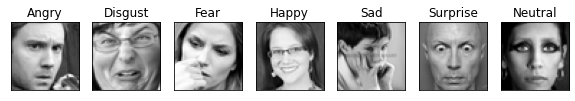

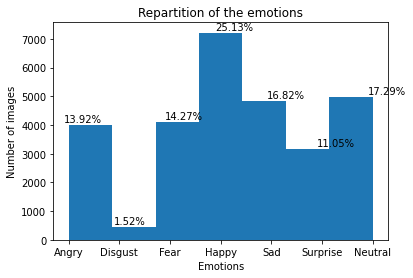

In [16]:
#VISUALIZATION OF THE DATA

#We have to visualize the data in order to see if the data is balanced or not
# - Visualize the data
# - Plot the repartition of the emotions

# - Visualize the data
#Plot one image of each emotion
fig, ax = plt.subplots(1, 7, figsize=(10, 10))
for i in range(7):
    ax[i].imshow(x[y==i][0].reshape(48, 48), cmap='gray')
    ax[i].set_title(EMOTIONS[i])
    #WE remove the ticks
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

# - Plot the repartition of the emotions
plt.hist(y, bins=7)
plt.title('Repartition of the emotions')
plt.xlabel('Emotions')
plt.ylabel('Number of images')
plt.xticks(np.arange(7), EMOTIONS)
#percentage of each emotion
for i in range(7):
    plt.text(x=i-0.1, y=np.sum(y==i)+100, s=str(np.round(np.sum(y==i)/len(y)*100, 2))+'%')
plt.show()

#We can see that the data is not balanced, we have more images of happy and very few images of disgust

### **PRE-PROCESSING**

In [ ]:
#DATA PREPROCESSING

#We have to normalize the features and one hot encode the labels
#We also have to split the data into training, testing and validation

#Features normalization
x = x/255.0

#Labels one hot encoding
y = to_categorical(y)

#Split the data into training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TEST_RATIO, random_state=RANDOM_STATE)

#Split the training data into training and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=VAL_RATIO, random_state=RANDOM_STATE)


## **MODEL ARCHITECTURE**

In [2]:
############################################################################################################

#WE DEFINE THE CONSTANTS
REGULARIZATION = 0.01 #The regularization parameter
LEARNING_RATE = 0.001 #The learning rate
IMG_SIZE = 48 #The size of the images
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 1) #The shape of the images
OUTPUT_SHAPE = 7 #The shape of the output (number of classes)

############################################################################################################

# ------------------------------ #
# ------------------------------ #
# IMPORTANT:

#YOU HAVE TO CHOOSE THE MODEL THAT YOU WANT TO USE BY EXECUTING ONE CELL AMONG THE NEXT 2 FOLLOWING CELLS

# ------------------------------ #

### <font color='SKY BLUE'>**FIRST MODEL - RESIDUAL MODEL**

In [ ]:
#BUILDING THE MODEL

#We define the input
input = Input(shape=IMG_SHAPE)

#We add twice: one convolutional layer with Batch Normalization
x = Conv2D(9, (3, 3), strides=(1, 1), kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION), use_bias=False)(input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(9, (3, 3), strides=(1, 1), kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION), use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

#We will repeat the following 4 times:
#-- Then we will do in parallel: one convolutional layer with Batch Normalization
#-- and twice: one depth-wise seperable convolutional layer with Batch Normalization followed by a max pooling layer
#-- then we will add the two branches

#First repetition
#The convolutional layer with Batch Normalization
residual_1 = Conv2D(18, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual_1 = BatchNormalization()(residual_1)
#The depth-wise seperable convolutional layer with Batch Normalization followed by a max pooling layer
x1 = SeparableConv2D(18, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION), use_bias=False)(x)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)
x1 = SeparableConv2D(18, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION), use_bias=False)(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x1)
#We add the two branches
x = layers.add([x1, residual_1])

#Second repetition
#The convolutional layer with Batch Normalization
residual_2 = Conv2D(36, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual_2 = BatchNormalization()(residual_2)
#The depth-wise seperable convolutional layer with Batch Normalization followed by a max pooling layer
x2 = SeparableConv2D(36, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION), use_bias=False)(x)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)
x2 = SeparableConv2D(36, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION), use_bias=False)(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x2)
#We add the two branches
x = layers.add([x2, residual_2])

#Third repetition
#The convolutional layer with Batch Normalization
residual_3 = Conv2D(72, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual_3 = BatchNormalization()(residual_3)
#The depth-wise seperable convolutional layer with Batch Normalization followed by a max pooling layer
x3 = SeparableConv2D(72, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION), use_bias=False)(x)
x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)
x3 = SeparableConv2D(72, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION), use_bias=False)(x3)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x3)
#We add the two branches
x = layers.add([x3, residual_3])


#Fourth repetition
#The convolutional layer with Batch Normalization
residual_4 = Conv2D(144, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual_4 = BatchNormalization()(residual_4)
#The depth-wise seperable convolutional layer with Batch Normalization followed by a max pooling layer
x4 = SeparableConv2D(144, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION), use_bias=False)(x)
x4 = BatchNormalization()(x4)
x4 = Activation('relu')(x4)
x4 = SeparableConv2D(144, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION), use_bias=False)(x4)
x4 = BatchNormalization()(x4)
x4 = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x4)
#We add the two branches
x = layers.add([x4, residual_4])


#Now we add a convolutional layer then a global average pooling layer and then a softmax layer
x = Conv2D(OUTPUT_SHAPE, (3, 3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax')(x)

#We define the model
model = Model(input, output)



### <font color='SKY BLUE'> **SECOND MODEL - BASIC CNN MODEL**

In [ ]:
#BUILDING THE MODEL
#We will use the Sequential API to build the model

basic_model = Sequential()

# Layer 1
basic_model.add(Conv2D(16, kernel_size=(7, 7), padding='same', input_shape=IMG_SHAPE))
basic_model.add(BatchNormalization())
basic_model.add(Activation('relu'))
basic_model.add(Conv2D(16, kernel_size=(7, 7), padding='same'))
basic_model.add(BatchNormalization())
basic_model.add(Activation('relu'))
basic_model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
basic_model.add(Dropout(.5))

# Layer 2
basic_model.add(Conv2D(32, kernel_size=(5, 5), padding='same'))
basic_model.add(BatchNormalization())
basic_model.add(Conv2D(32, kernel_size=(5, 5), padding='same'))
basic_model.add(BatchNormalization())
basic_model.add(Activation('relu'))
basic_model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
basic_model.add(Dropout(.5))

# Layer 3
basic_model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
basic_model.add(BatchNormalization())
basic_model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
basic_model.add(BatchNormalization())
basic_model.add(Activation('relu'))
basic_model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
basic_model.add(Dropout(.5))

# Layer 4
basic_model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
basic_model.add(BatchNormalization())
basic_model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
basic_model.add(BatchNormalization())
basic_model.add(Activation('relu'))
basic_model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
basic_model.add(Dropout(.5))

# Output
basic_model.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
basic_model.add(BatchNormalization())
basic_model.add(Conv2D(OUTPUT_SHAPE, kernel_size=(3, 3), padding='same'))
basic_model.add(GlobalAveragePooling2D())
basic_model.add(Activation('softmax'))

#We render basic_model into model
model = basic_model

model.summary()


## **COMPILE MODEL**

In [ ]:
#We compile the model

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

## **MODEL TRAINING**

In [ ]:
############################################################################################################

#WE DEFINE THE CONSTANTS
EPOCHS = 3 #Number of epochs
BATCH_SIZE = 32 #Batch size
WITH_DATA_AUGMENTATION = False #Use of data augmentation or not

# ------------------------------ #
#SPECIFIC FOR THE DATA AUGMENTATION
# ------------------------------ #

#We define the data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest')

# ------------------------------ #
# ------------------------------ #


In [ ]:
#TRAINING THE MODEL

#We train the model
if WITH_DATA_AUGMENTATION:
    train_generator = data_augmentation.flow(x_train, y_train, batch_size=BATCH_SIZE)
    steps_per_epoch = train_generator.n // train_generator.batch_size
    history = model.fit(train_generator, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, validation_data=(x_val, y_val))
else:
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val))


In [ ]:
#PLOTTING THE RESULTS

#We plot the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## **MODEL EVALUATION**

In [ ]:
############################################################################################################

#WE DEFINE THE CONSTANTS
IDEAL_EPOCH = 1 #We choose the ideal epoch (thanks to the plot above)

############################################################################################################

In [ ]:
#EVALUATING THE MODEL

# - First we have to train again the model with the whole training set (train + validation)

x_train_val = np.concatenate((x_train, x_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

if WITH_DATA_AUGMENTATION:
    train_generator = data_augmentation.flow(x_train_val, y_train_val, batch_size=BATCH_SIZE)
    steps_per_epoch = train_generator.n // train_generator.batch_size
    history = model.fit(train_generator, epochs=IDEAL_EPOCH, steps_per_epoch=steps_per_epoch)
else:
    history = model.fit(x_train_val, y_train_val, batch_size=BATCH_SIZE, epochs=IDEAL_EPOCH, verbose=0)


# - Then we evaluate the model on the test set

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


In [ ]:
#CONFUSION MATRIX

EMOTIONS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

#We compute the predictions
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

#We store the true labels
y_true = np.argmax(y_test, axis=1)

#We compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

#We plot the confusion matrix
df_cm = pd.DataFrame(cm, index = [i for i in EMOTIONS],
                    columns = [i for i in EMOTIONS])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## **WE SAVE THE MODEL**

In [ ]:
#We save the model

############################################################################################################
#WE DEFINE THE CONSTANTS
name = 'model' #Name of the model

############################################################################################################



data_augmented = 'data_augmented' if WITH_DATA_AUGMENTATION else ''

model.save(name + '_' + data_augmented + '.h5')

## **WE LOAD A MODEL**

In [ ]:
#We load the model

############################################################################################################
#WE DEFINE THE CONSTANTS
file_name = 'model' #Name of the file

############################################################################################################

model = load_model(file_name + '.h5')
